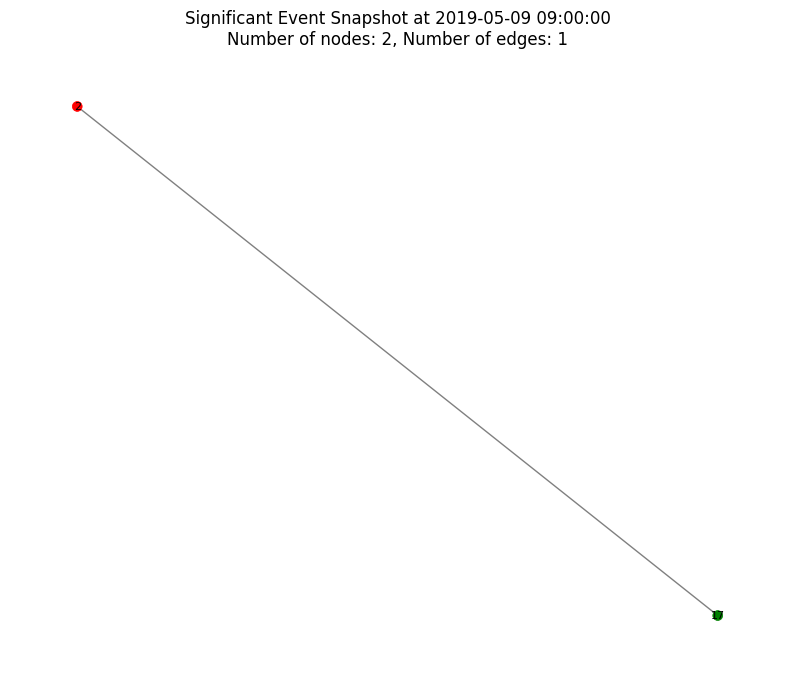

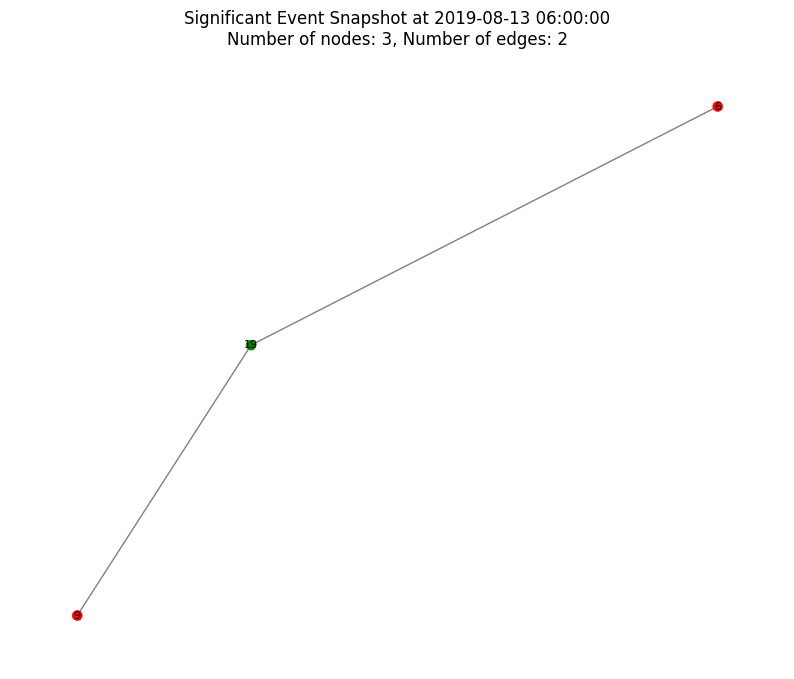

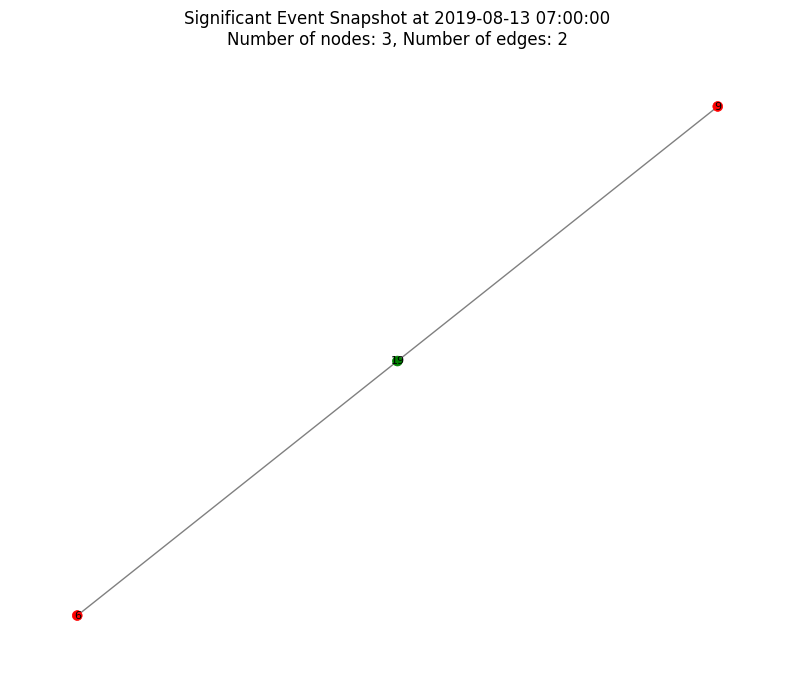

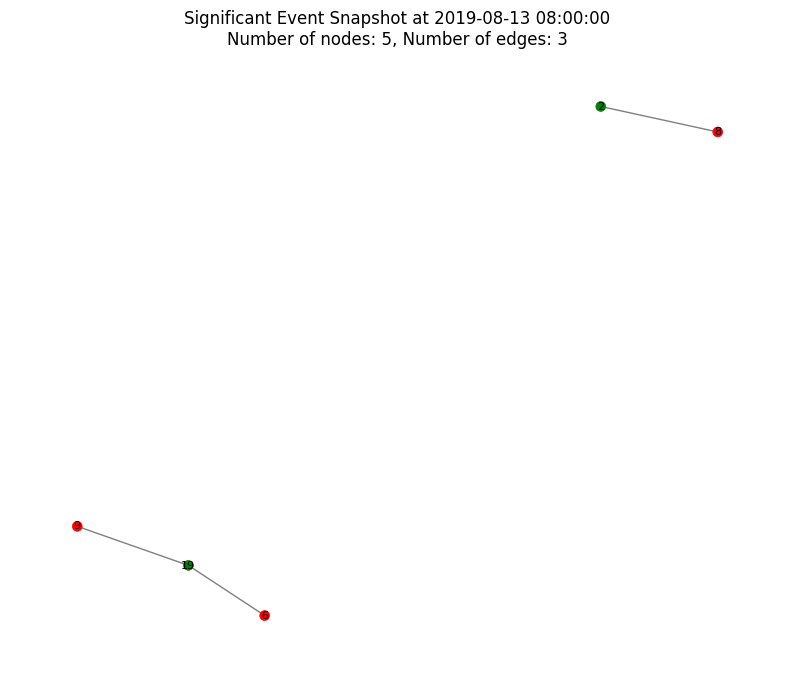

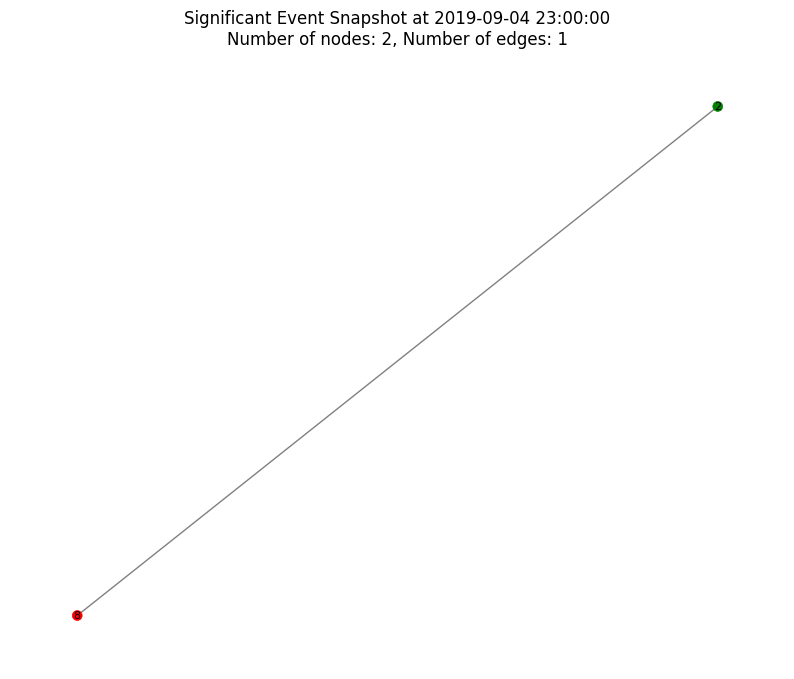

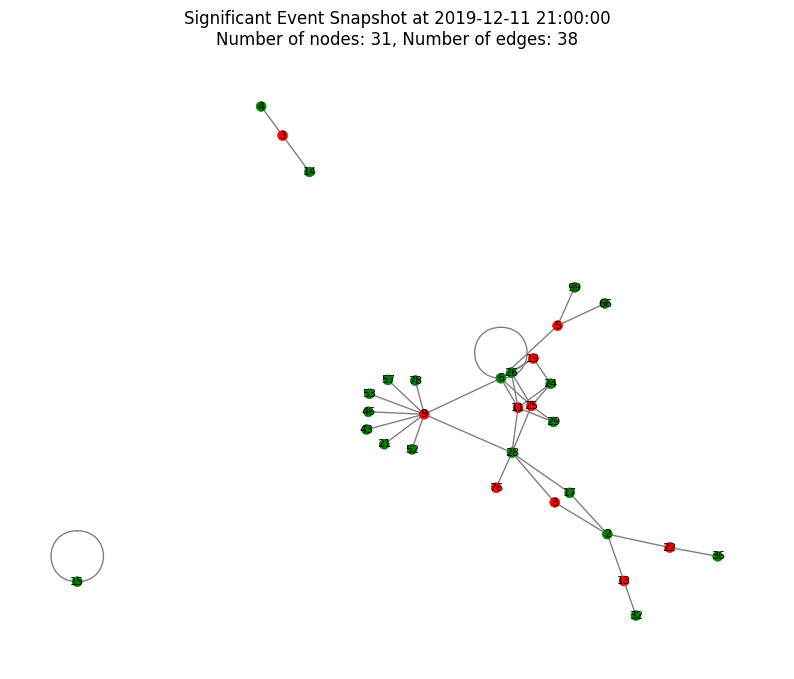

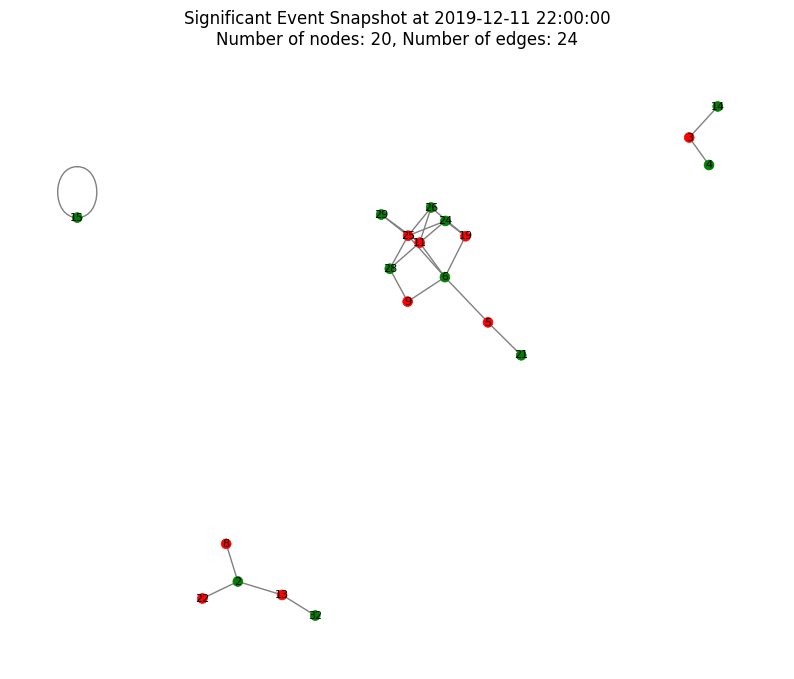

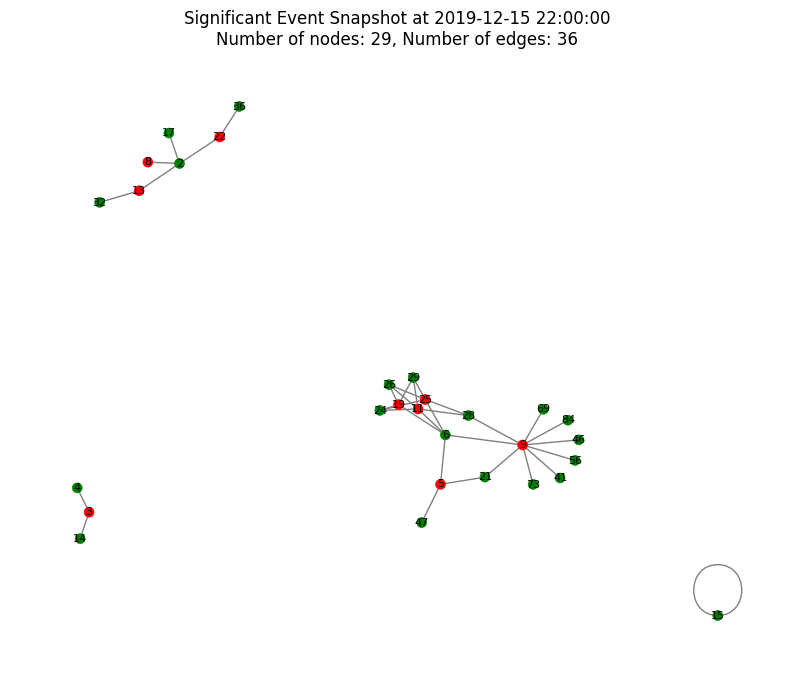

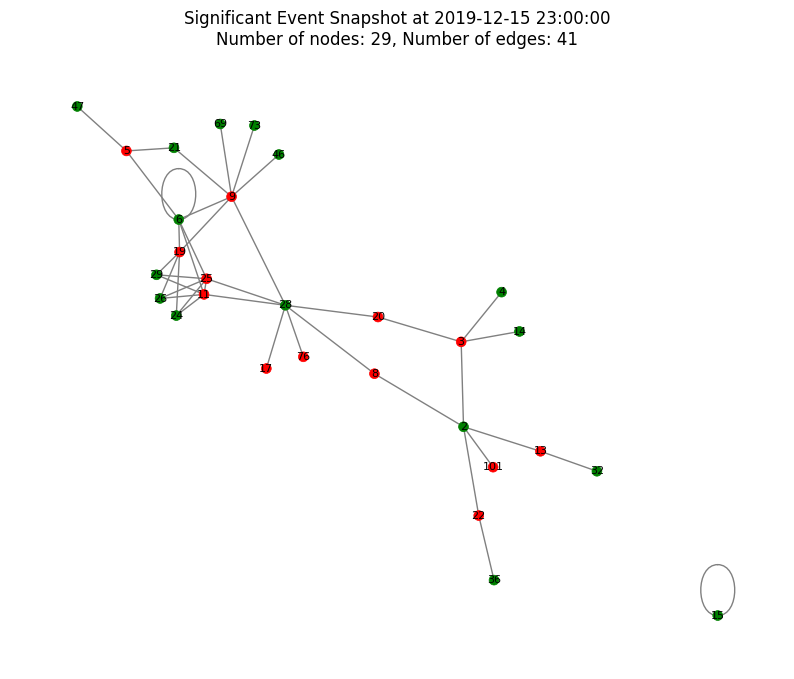

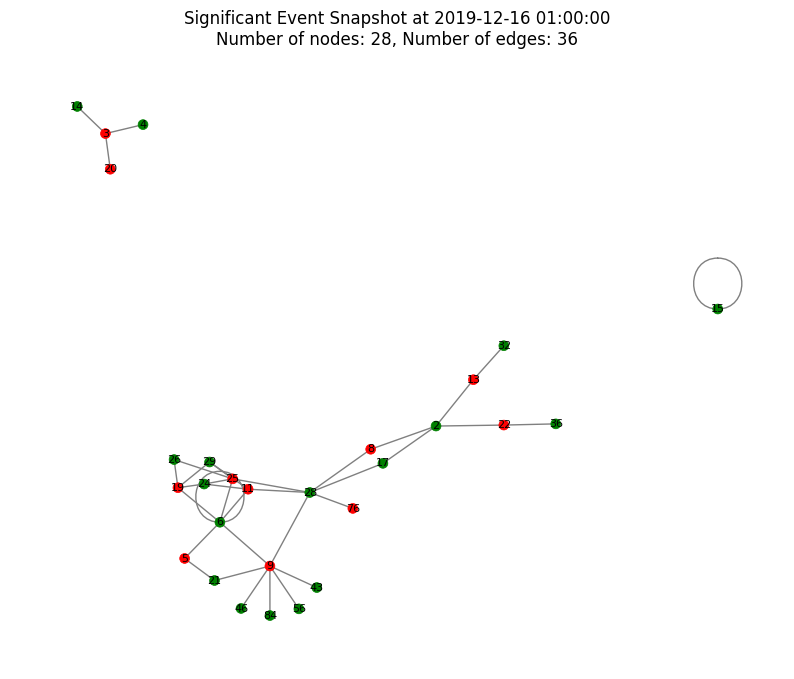

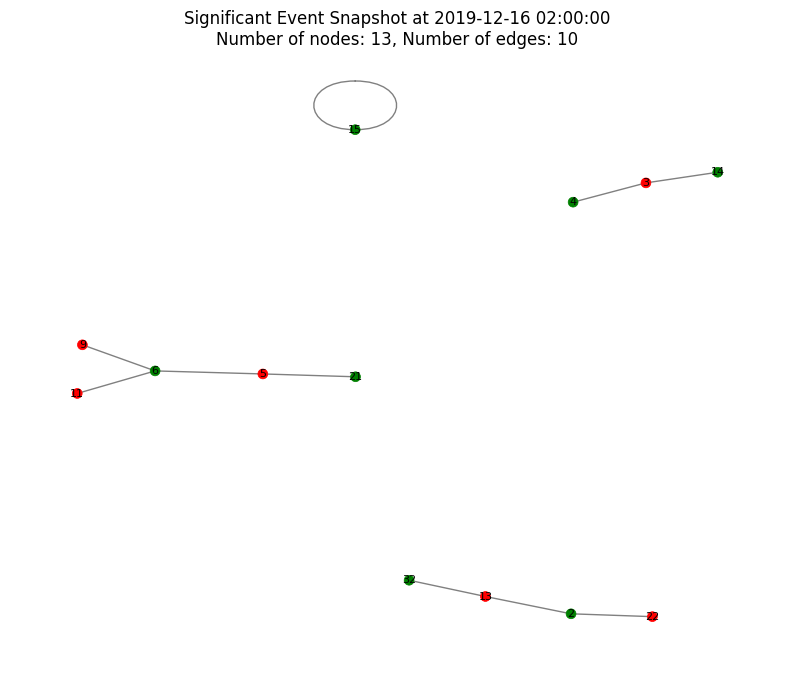

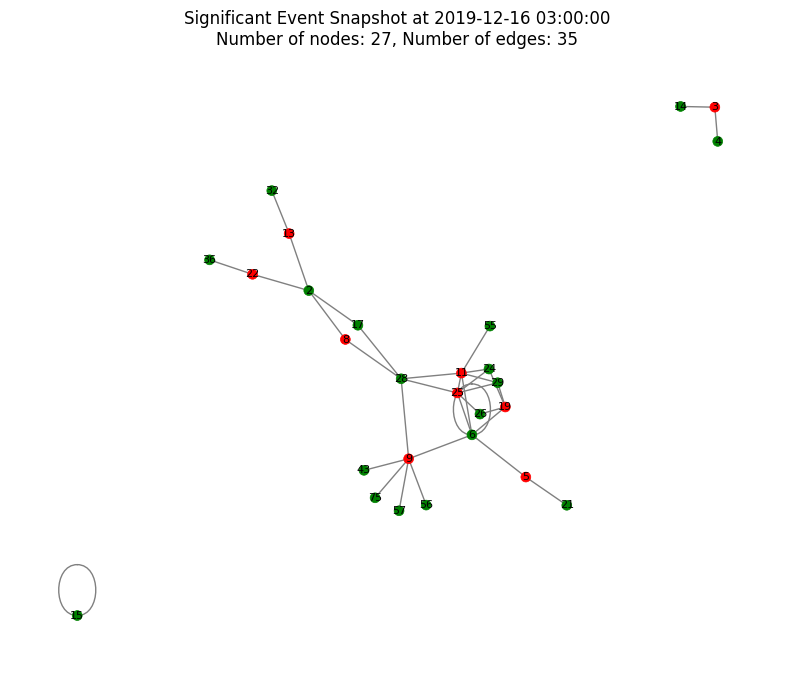

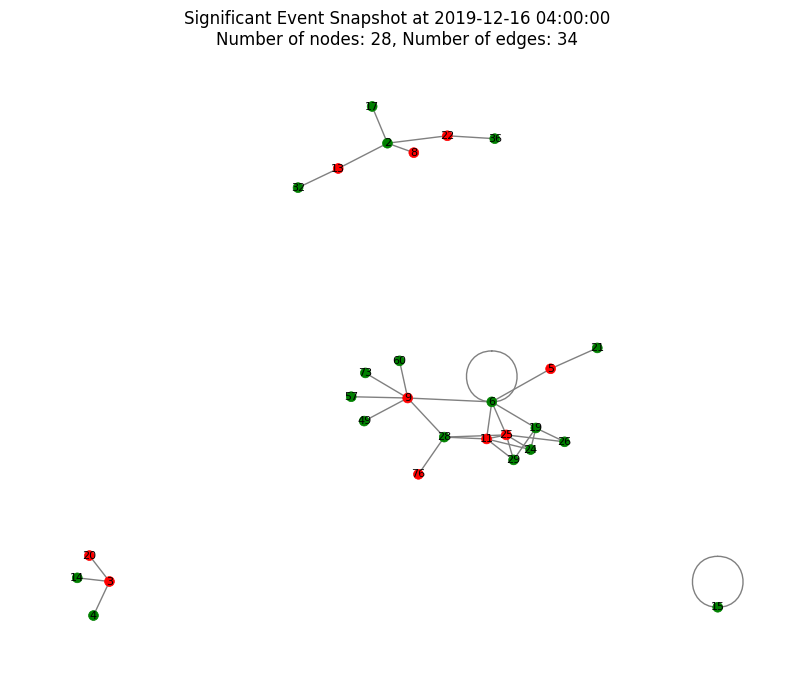

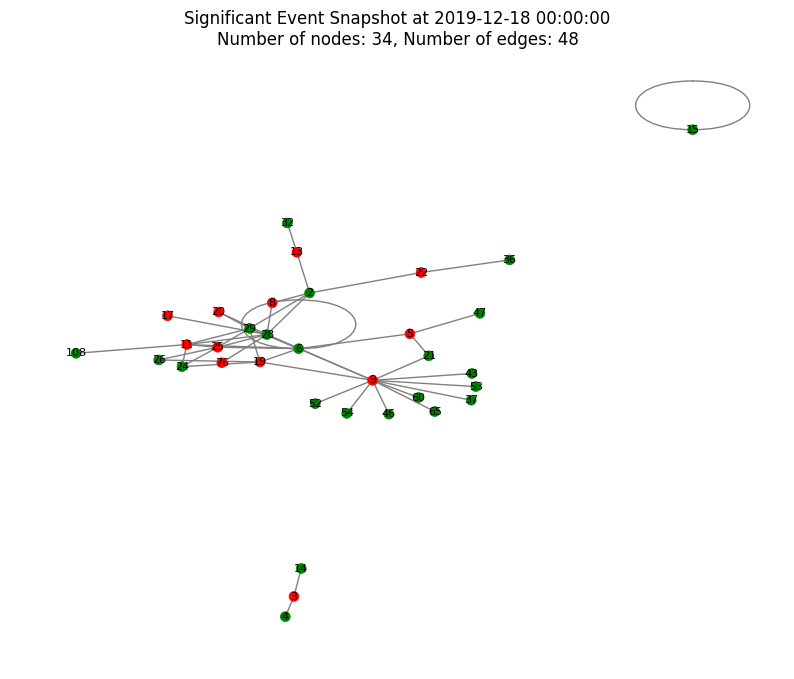

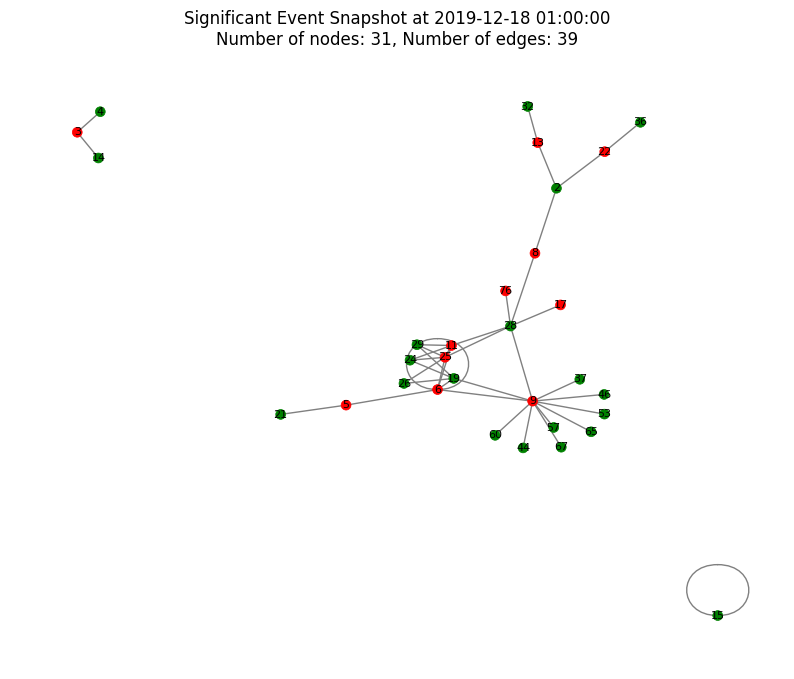

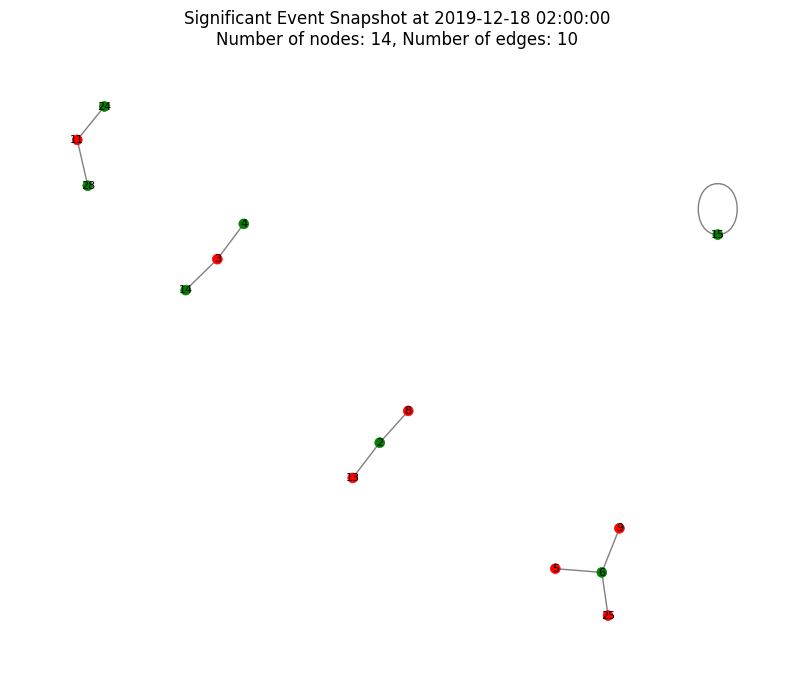

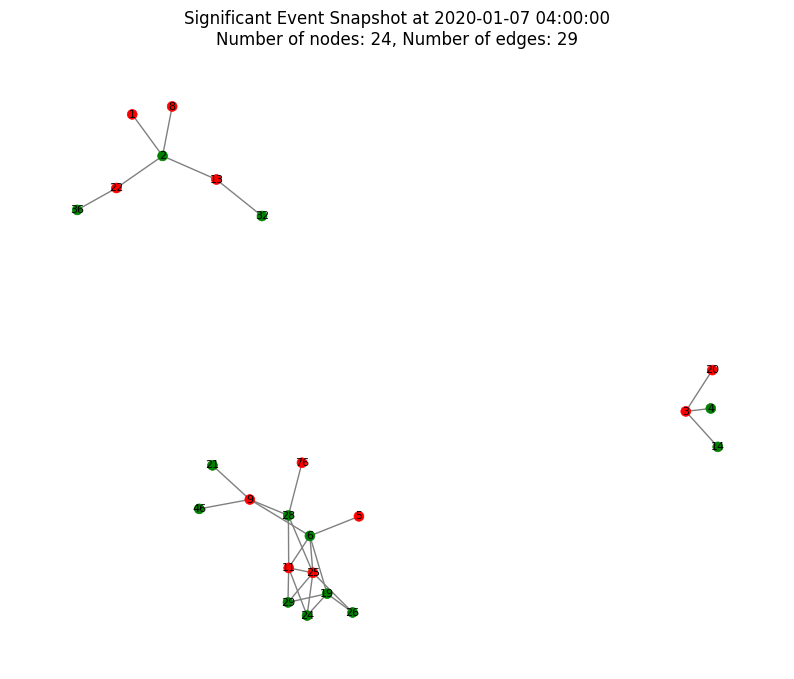

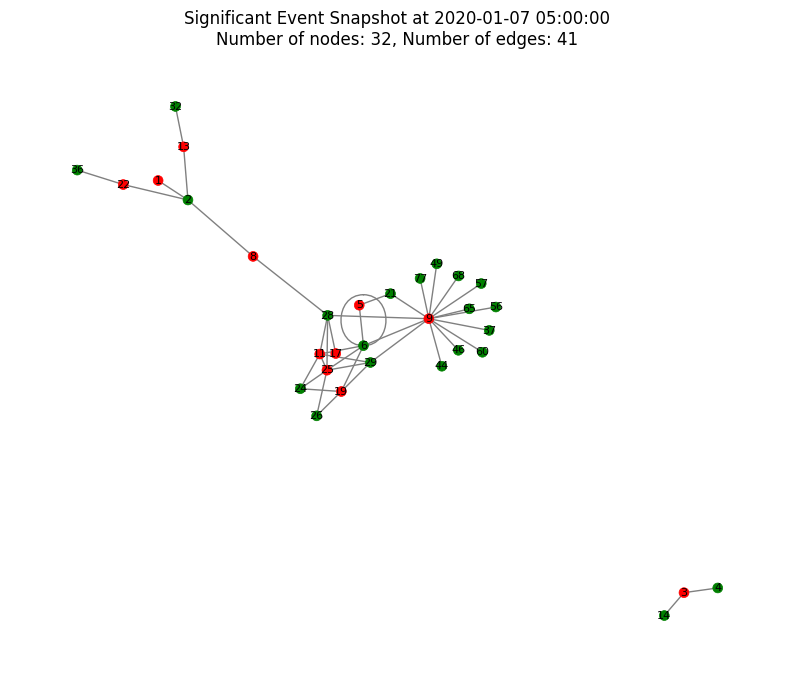

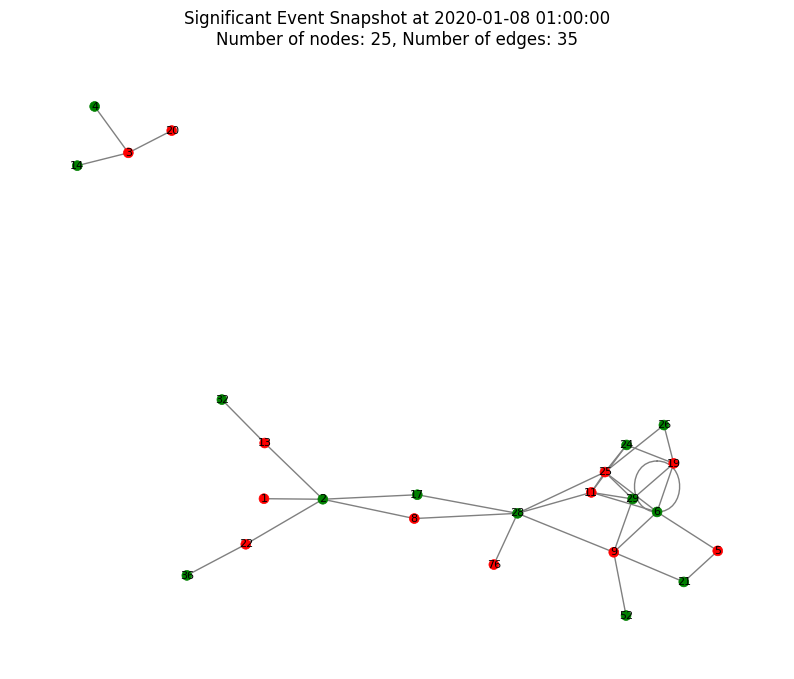

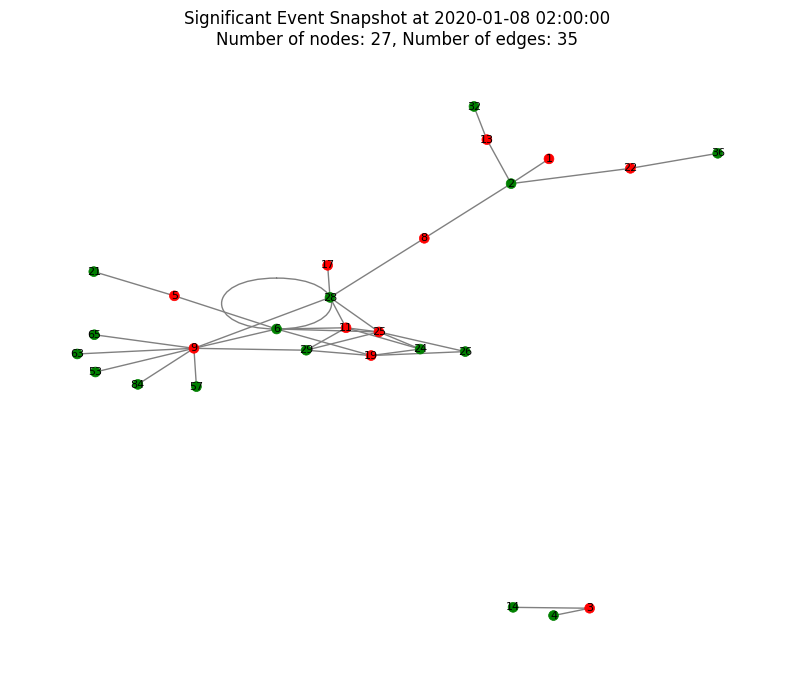

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('X-IIoTID.csv', low_memory=False)

# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
df.dropna(subset=['Timestamp'], inplace=True)
df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s').dt.floor('H')

# Initialize the snapshots dictionary and a dictionary for node IDs
snapshots = {}
node_ids = {}
current_id = 1  # Start with an ID of 1

for index, row in df.iterrows():
    snapshot_id = row['timestamp']

    # Check if the IP already has an ID assigned, if not, assign a new one
    for ip in [row['Scr_IP'], row['Des_IP']]:
        if ip not in node_ids:
            node_ids[ip] = current_id
            current_id += 1

    # Use the node ID instead of the IP address directly
    src_id = node_ids[row['Scr_IP']]
    dest_id = node_ids[row['Des_IP']]

    # Assuming a column 'class3' dictates the label
    node_label_src = 'Normal' if row['class3'] == 'NormalActivity' else 'Attack'
    node_label_dest = 'Normal'  # Assume destinations are 'Normal', adjust as needed

    if snapshot_id not in snapshots:
        snapshots[snapshot_id] = nx.Graph()

    snapshots[snapshot_id].add_node(src_id, label=node_label_src, ip=row['Scr_IP'])
    snapshots[snapshot_id].add_node(dest_id, label=node_label_dest, ip=row['Des_IP'])
    snapshots[snapshot_id].add_edge(src_id, dest_id)

# Sort the snapshots by timestamp
sorted_timestamps = sorted(snapshots.keys())

# Set a limit on the number of snapshots to visualize if there are many
max_snapshots_to_visualize = 20  # Adjust as needed

# Visualization loop for each snapshot, now in chronological order
for i, timestamp in enumerate(sorted_timestamps):
    if i >= max_snapshots_to_visualize:
        break  # Limit the number of visualized snapshots
    
    graph = snapshots[timestamp]
    plt.figure(figsize=(10, 8))
    plt.title(f'Significant Event Snapshot at {timestamp}\nNumber of nodes: {graph.number_of_nodes()}, Number of edges: {graph.number_of_edges()}')
    
    # Compute layout for visualizing the graph
    pos = nx.spring_layout(graph)
    
    # Prepare color map for nodes based on their label
    node_colors = ['green' if graph.nodes[node].get('label') == 'Normal' else 'red' for node in graph.nodes()]
    
    # Draw the graph with nodes colored by label, using node ID as the label
    nx.draw(graph, pos, with_labels=True, node_size=50, edge_color="gray", linewidths=0.5, font_size=8, node_color=node_colors)
    
    plt.axis('off')  # Optionally remove the axis for a cleaner look
    plt.show()
